# LIBRARIES

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import librosa
import librosa.display
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
import kagglehub

# Download latest version
path1= kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path1)

# Download latest version
path2 = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path2)


# Download latest version
path3 = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print("Path to dataset files:", path3)

# Download latest version
path4 = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path4)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio
Path to dataset files: /kaggle/input/cremad
Path to dataset files: /kaggle/input/surrey-audiovisual-expressed-emotion-savee
Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


# RAVDESS SPEECH DATASETS

In [4]:
ravdess = path1
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [5]:
file_emotion = []
file_path = []
for actor_folder in ravdess_directory_list:
    actor_path = os.path.join(ravdess, actor_folder)

    # Make sure it’s a directory (not a hidden file, etc.)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'):
                parts = file_name.split('.')[0].split('-')

                # Extract the emotion part (index 2)
                emotion = int(parts[2])
                full_path = os.path.join(actor_path, file_name)

                file_emotion.append(emotion)
                file_path.append(full_path)

In [6]:
ravdess_df = pd.DataFrame({'Emotion': file_emotion,
                           'Path': file_path})
ravdess_df

,Emotion,Path
0,8,/kaggle/input/ravdess-emotional-speech-audio/A...
1,1,/kaggle/input/ravdess-emotional-speech-audio/A...
2,7,/kaggle/input/ravdess-emotional-speech-audio/A...
3,7,/kaggle/input/ravdess-emotional-speech-audio/A...
4,1,/kaggle/input/ravdess-emotional-speech-audio/A...
...,...,...
1435,6,/kaggle/input/ravdess-emotional-speech-audio/A...
1436,5,/kaggle/input/ravdess-emotional-speech-audio/A...
1437,4,/kaggle/input/ravdess-emotional-speech-audio/A...
1438,7,/kaggle/input/ravdess-emotional-speech-audio/A...


In [7]:
ravdess_df.Emotion.replace({1: 'neutral',
                            2: 'neutral',
                            3: 'happy',
                            4: 'sad',
                            5: 'angry',
                            6: 'fearful',
                            7: 'disgust',
                            8: 'surprised'}, inplace=True)
ravdess_df

/tmp/ipython-input-7-1233336508.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotion.replace({1: 'neutral',


,Emotion,Path
0,surprised,/kaggle/input/ravdess-emotional-speech-audio/A...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...
...,...,...
1435,fearful,/kaggle/input/ravdess-emotional-speech-audio/A...
1436,angry,/kaggle/input/ravdess-emotional-speech-audio/A...
1437,sad,/kaggle/input/ravdess-emotional-speech-audio/A...
1438,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...


In [8]:
ravdess_df.Emotion.value_counts()

,count
Emotion,
neutral,288
surprised,192
disgust,192
fearful,192
sad,192
happy,192
angry,192


# CREMA-D DATASETS


In [9]:
crema = path2 +'/AudioWAV'
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

# CREMA-D files are directly in the main folder, not subfolders
for file_name in os.listdir(crema):
    if file_name.endswith('.wav'):
        parts = file_name.split('_')

        # Emotion is the third part (index 2), e.g., 'ANG'
        emotion_str = parts[2]
        full_path = os.path.join(crema, file_name)

        file_emotion.append(emotion_str)
        file_path.append(full_path)


In [10]:
crema_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
print(crema_df.Emotion.value_counts())

Emotion
DIS    1271
HAP    1271
SAD    1271
FEA    1271
ANG    1271
NEU    1087
Name: count, dtype: int64


In [11]:
crema_df.Emotion.replace({'ANG': 'angry',
                          'DIS': 'disgust',
                          'FEA': 'fearful',
                          'HAP': 'happy',
                          'SAD': 'sad',
                          'NEU': 'neutral'}, inplace=True)
crema_df

/tmp/ipython-input-11-2943398656.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crema_df.Emotion.replace({'ANG': 'angry',


,Emotion,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
...,...,...
7437,angry,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438,angry,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439,angry,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440,sad,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav


In [12]:
savee = path3+'/ALL'
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for i in savee_directory_list:
    part = i.split('.')[0].split('_')
    file_emotion.append(part[1][:-2])
    file_path.append(savee + '/' + i)

print(len(file_path))

480


In [13]:
savee_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
print(savee_df.Emotion.value_counts())

Emotion
n     120
f      60
h      60
d      60
a      60
su     60
sa     60
Name: count, dtype: int64


In [14]:
savee_df.Emotion.replace({'n': 'neutral',
                          'd': 'disgust',
                          'a': 'angry',
                          'f': 'fearful',
                          'h': 'happy',
                          'sa': 'sad',
                          'su': 'surprised'}, inplace=True)
savee_df

/tmp/ipython-input-14-3901992850.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  savee_df.Emotion.replace({'n': 'neutral',


,Emotion,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fearful,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...
...,...,...
475,surprised,/kaggle/input/surrey-audiovisual-expressed-emo...
476,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
477,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
478,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


# TESS DATASETS

In [15]:
tess = path4+'/TESS Toronto emotional speech set data'
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for i in tess_directory_list:

    file = os.listdir(tess + '/' + i)
    for f in file:

        part = f.split('.')[0].split('_')
        file_emotion.append(part[2])
        file_path.append(tess + '/' + i + '/' + f)

In [16]:
tess_df = pd.DataFrame({'Emotion': file_emotion,
                        'Path': file_path})
print(tess_df.Emotion.value_counts())

Emotion
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64


In [17]:
tess_df.Emotion.replace({'fear': 'fearful',
                         'ps': 'surprised'}, inplace=True)
print(tess_df)

        Emotion                                               Path
0       fearful  /kaggle/input/toronto-emotional-speech-set-tes...
1       fearful  /kaggle/input/toronto-emotional-speech-set-tes...
2       fearful  /kaggle/input/toronto-emotional-speech-set-tes...
3       fearful  /kaggle/input/toronto-emotional-speech-set-tes...
4       fearful  /kaggle/input/toronto-emotional-speech-set-tes...
...         ...                                                ...
2795  surprised  /kaggle/input/toronto-emotional-speech-set-tes...
2796  surprised  /kaggle/input/toronto-emotional-speech-set-tes...
2797  surprised  /kaggle/input/toronto-emotional-speech-set-tes...
2798  surprised  /kaggle/input/toronto-emotional-speech-set-tes...
2799  surprised  /kaggle/input/toronto-emotional-speech-set-tes...

[2800 rows x 2 columns]


/tmp/ipython-input-17-3743040608.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tess_df.Emotion.replace({'fear': 'fearful',


# Combined DATASETS


In [18]:
combined_df = pd.concat([ravdess_df, savee_df, tess_df, crema_df])
print(combined_df.Emotion.value_counts())

Emotion
disgust      1923
sad          1923
fearful      1923
happy        1923
angry        1923
neutral      1895
surprised     652
Name: count, dtype: int64


# Visualization


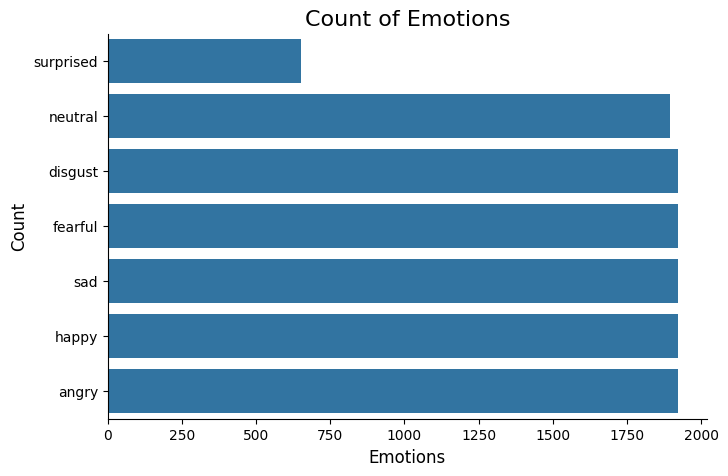

In [19]:
fig = plt.figure(figsize=(17, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(combined_df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# RESAMPLE

In [20]:
# Giả sử đây là DataFrame bạn đang dùng
df_all = pd.concat([ravdess_df, crema_df, savee_df, tess_df], ignore_index=True)

# Kiểm tra số lượng mỗi lớp
print(df_all['Emotion'].value_counts())

# Lấy class phổ biến nhất để làm mốc oversample
max_count = df_all['Emotion'].value_counts().max()

# Tách các lớp theo emotion
df_balanced = pd.DataFrame()

for emotion in df_all['Emotion'].unique():
    df_emotion = df_all[df_all['Emotion'] == emotion]
    if len(df_emotion) < max_count:
        df_emotion_upsampled = resample(df_emotion,
                                        replace=True,
                                        n_samples=max_count,
                                        random_state=42)
    else:
        df_emotion_upsampled = df_emotion
    df_balanced = pd.concat([df_balanced, df_emotion_upsampled])

# Shuffle lại
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Kiểm tra lại
print(df_balanced['Emotion'].value_counts())
print(df_balanced.columns)


Emotion
disgust      1923
sad          1923
fearful      1923
happy        1923
angry        1923
neutral      1895
surprised     652
Name: count, dtype: int64
Emotion
surprised    1923
disgust      1923
sad          1923
happy        1923
angry        1923
fearful      1923
neutral      1923
Name: count, dtype: int64
Index(['Emotion', 'Path'], dtype='object')


### DATA AUGMENTATION

In [21]:
def noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.randn(len(data))

def shift(data, shift_max=0.2, sr=22050):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(data, shift)

def stretch(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

In [22]:
def augment_audio(y, sr):
    return [
        noise(y),
        shift(y),
        stretch(y, rate=random.uniform(0.8, 1.2)),
        pitch(y, sr=sr, n_steps=random.randint(-2, 2))
    ] # ham augment tong hop moi path

import numpy as np
import librosa

def audio_to_melspectrogram_3d_from_wave(y, sr=16000, n_mels=64, frame_length=2.0, fixed_n_frames=10):
    """
    Convert audio waveform to a 3D array of mel-spectrograms with fixed shape.

    Args:
        y: NumPy array of audio waveform (shape: (n_samples,))
        sr: Sampling rate (default: 22050 Hz)
        n_mels: Number of mel bands (default: 64)
        frame_length: Length of each frame in seconds (default: 2.0)
        fixed_n_frames: Desired number of frames in output (default: 10)

    Returns:
        NumPy array of shape (fixed_n_frames, n_mels, time_steps, 1)
    """
    # Calculate samples per frame
    samples_per_frame = int(frame_length * sr)

    # Split audio into frames
    duration = len(y) / sr
    total_frames = int(np.ceil(duration / frame_length))  # Round up to include partial frames
    frames = []

    for i in range(total_frames):
        start = i * samples_per_frame
        end = min(start + samples_per_frame, len(y))
        y_frame = y[start:end]

        # Pad frame if too short
        if len(y_frame) < samples_per_frame:
            y_frame = np.pad(y_frame, (0, samples_per_frame - len(y_frame)), mode='constant')

        # Compute mel-spectrogram for the frame
        mel = librosa.feature.melspectrogram(y=y_frame, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        frames.append(mel_db)

    # Convert to NumPy array and add channel dimension
    frames = np.array(frames)[..., np.newaxis]  # Shape: (n_frames, n_mels, time_steps, 1)

    # Pad or truncate to fixed_n_frames
    current_n_frames = frames.shape[0]
    if current_n_frames < fixed_n_frames:
        # Pad with zero-filled spectrograms
        pad_shape = (fixed_n_frames - current_n_frames, n_mels, frames.shape[2], 1)
        padded_frames = np.zeros(pad_shape)
        frames = np.concatenate([frames, padded_frames], axis=0)
    elif current_n_frames > fixed_n_frames:
        # Truncate excess frames
        frames = frames[:fixed_n_frames]

    return frames  # Shape: (fixed_n_frames, n_mels, time_steps, 1)
def audio_to_augmented_spectrograms(path, sr=22050):
    y, sr = librosa.load(path, sr=sr)
    tensors = [audio_to_melspectrogram_3d_from_wave(y, sr)]
    for aug in augment_audio(y, sr):
        tensors.append(audio_to_melspectrogram_3d_from_wave(aug, sr))
    return tensors

In [23]:
X = df_balanced['Path']
y = df_balanced['Emotion']

print(X)
print(y)

0        /kaggle/input/toronto-emotional-speech-set-tes...
1        /kaggle/input/cremad/AudioWAV/1080_IEO_DIS_HI.wav
2        /kaggle/input/ravdess-emotional-speech-audio/A...
3        /kaggle/input/ravdess-emotional-speech-audio/A...
4        /kaggle/input/cremad/AudioWAV/1090_ITS_DIS_XX.wav
                               ...                        
13456    /kaggle/input/cremad/AudioWAV/1023_IWL_DIS_XX.wav
13457    /kaggle/input/toronto-emotional-speech-set-tes...
13458    /kaggle/input/toronto-emotional-speech-set-tes...
13459    /kaggle/input/toronto-emotional-speech-set-tes...
13460    /kaggle/input/surrey-audiovisual-expressed-emo...
Name: Path, Length: 13461, dtype: object
0        surprised
1          disgust
2              sad
3        surprised
4          disgust
           ...    
13456      disgust
13457        angry
13458      disgust
13459    surprised
13460      fearful
Name: Emotion, Length: 13461, dtype: object


In [24]:
# First split: separate out test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
# Second split:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# Data augument just on training set
print(y_train)

10013      disgust
2367       neutral
7812         happy
1410           sad
10087    surprised
           ...    
9771           sad
11114        happy
3719         happy
4863           sad
9081       disgust
Name: Emotion, Length: 4038, dtype: object


In [25]:
#preprocess training set
# Define emotion mappings
emotion_mappings = {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3,
                    'fearful': 4, 'disgust': 5, 'surprised': 6}
reverse_mapping = {index: emotion for emotion, index in emotion_mappings.items()}

new_X_train, new_y_train = [], []
for per_X, per_y in zip(X_train, y_train):
    tensor = audio_to_augmented_spectrograms(per_X)  # List of spectrograms (original + augmented)
    if np.random.rand() < 0.3:
        # Include only the original spectrogram
        new_X_train.append(tensor[0])
        new_y_train.append(emotion_mappings[per_y])
    else:
        # Include all spectrograms (original + augmented)
        new_X_train.extend(tensor)
        new_y_train.extend([emotion_mappings[per_y]] * len(tensor))


In [26]:
new_X_train, new_y_train = np.array(new_X_train), np.array(new_y_train)

In [27]:
print(new_X_train[0])

[[[[-48.3483429 ]
   [-43.51903915]
   [-41.03778076]
   ...
   [-44.26537704]
   [-46.87763977]
   [-52.79131317]]

  [[-52.24565887]
   [-43.96456909]
   [-42.91184235]
   ...
   [-43.71372986]
   [-47.22694397]
   [-54.54354477]]

  [[-46.52078247]
   [-41.12683105]
   [-39.7123642 ]
   ...
   [-38.13570786]
   [-42.00167465]
   [-46.13437653]]

  ...

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]]


 [[[ -3.69237804]
   [ -5.77043629]
   [ -8.80574703]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[ -8.74354839]
   [ -9.39216137]
   [ -8.03921795]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[ -6.06758785]
   [ -6.25820446]
   [ -5.59606361]
 

In [28]:

#preprocess val and test set
def preprocess_audio(X, y, emotion_mappings, sr=16000):
    return (
        [audio_to_melspectrogram_3d_from_wave(*librosa.load(per_X, sr=sr)) for per_X in X],
        [emotion_mappings[per_y] for per_y in y]
    )

new_X_val, new_y_val = preprocess_audio(X_val, y_val, emotion_mappings)
new_X_test, new_y_test = preprocess_audio(X_test, y_test, emotion_mappings)
new_X_val, new_y_val =np.array(new_X_val), np.array(new_y_val)
new_X_test, new_y_test = np.array(new_X_test), np.array(new_y_test)

In [29]:

print(f"Training data shape: {new_X_train.shape}")
print(f"Validation data shape: {new_X_val.shape}")
print(f"Test data shape: {new_X_test.shape}")

Training data shape: (15250, 10, 64, 87, 1)
Validation data shape: (4038, 10, 64, 63, 1)
Test data shape: (5385, 10, 64, 63, 1)


In [30]:
print("NaN in X_train_3d:", np.any(np.isnan(new_X_train)))
print("Inf in X_train_3d:", np.any(np.isinf(new_X_train)))
print("NaN in y_train_onehot:", np.any(np.isnan(new_y_train)))
print("Inf in y_train_onehot:", np.any(np.isinf(new_y_train)))


NaN in X_train_3d: False
Inf in X_train_3d: False
NaN in y_train_onehot: False
Inf in y_train_onehot: False


# MODEL


In [31]:
# import tensorflow as tf
# from tensorflow.keras import models, layers
# import numpy as np

# # # 2. Improve the positional encoding function with better numerical stability
# def positional_encoding(seq_len, embed_dim):
#     pos = np.arange(seq_len)[:, np.newaxis]
#     i = np.arange(embed_dim)[np.newaxis, :]
#     # Use a more numerically stable calculation
#     angles = pos / np.power(10000, (2 * (i // 2)) / np.maximum(embed_dim, 1e-10))
#     pos_enc = np.zeros((seq_len, embed_dim))
#     pos_enc[:, 0::2] = np.sin(angles[:, 0::2])
#     pos_enc[:, 1::2] = np.cos(angles[:, 1::2])
#     # Ensure no NaN values
#     pos_enc = np.nan_to_num(pos_enc, nan=0.0)
#     return tf.cast(pos_enc, dtype=tf.float32)

# # 3. Improve the CustomEncoderLayer class with better numerical stability
# class CustomEncoderLayer(tf.keras.layers.Layer):
#     def __init__(self, num_heads, d_model, dropout_rate):
#         super(CustomEncoderLayer, self).__init__()
#         self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
#         self.dropout = layers.Dropout(dropout_rate)
#         self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

#     def call(self, x, training=None):
#         # Add small epsilon to avoid numerical instability
#         attn_output = self.mha(x, x)  # Self-attention
#         attn_output = self.dropout(attn_output, training=training)

#         # Use careful addition for residual connection
#         out = x + attn_output
#         out = self.layer_norm(out)  # Normalization

#         # Add extra safety check
#         out = tf.where(tf.math.is_nan(out), tf.zeros_like(out), out)
#         return out

# # Full model
# # 4. Modify the model building function with gradient clipping and lower learning rate
# def build_3d_cnn_transformer_model(input_shape, num_classes, embed_dim=256, num_layers=4, num_heads=4, dropout_rate=0.2):
#     inputs = layers.Input(shape=input_shape)

#     # 3D CNN - simplified
#     x = layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling3D((1, 2, 2))(x)


#     x = layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling3D((1, 2, 2))(x)
#     x = layers.Dropout(0.3)(x)


#     x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling3D((1, 2, 2))(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling3D((1, 2, 2))(x)
#     x = layers.Dropout(0.3)(x)


#     # Reshape for Transformer - simplify the model by using fewer layers
#     batch_size, time, height, width, channels = x.shape
#     x = layers.Reshape((time * height * width, channels))(x)

#     # Projection with smaller embedding dimension
#     x = layers.Dense(embed_dim)(x)

#     # Add positional encoding
#     seq_len = time * height * width
#     pos_enc = positional_encoding(seq_len=seq_len, embed_dim=embed_dim)
#     x = x + pos_enc

#     # Transformer encoder with fewer layers (less complexity)
#     for _ in range(num_layers):
#         x = CustomEncoderLayer(num_heads=num_heads, d_model=embed_dim, dropout_rate=dropout_rate)(x)

#     # Pooling and classification
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dense(128, activation='relu')(x)  # Smaller dense layer
#     x = layers.BatchNormalization()(x)

#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     return models.Model(inputs, outputs)

In [32]:
# # 5. Compile the model with a lower learning rate and gradient clipping
# model = build_3d_cnn_transformer_model(input_shape=(10, 64, 87, 1), num_classes=len(emotion_mappings))

# # Use a much lower learning rate and gradient clipping
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])




In [33]:
# # Add more callbacks for monitoring and preventing NaN
# class TerminateOnNaN(tf.keras.callbacks.Callback):
#     def on_batch_end(self, batch, logs=None):
#         logs = logs or {}
#         loss = logs.get('loss')
#         if loss is not None and (np.isnan(loss) or np.isinf(loss)):
#             print(f'Batch {batch}: Invalid loss, terminating training')
#             self.model.stop_training = True

# # Define callbacks
# callbacks = [

#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=3,
#         min_lr=1e-7,
#         verbose=1
#     ),
#     tf.keras.callbacks.ModelCheckpoint(
#         'best_model.h5',
#         save_best_only=True,
#         monitor='val_loss',
#         verbose=1
#     ),
#     TerminateOnNaN()
# ]

# # Train with a smaller batch size
# history = model.fit(
#     new_X_train,
#     new_y_train,
#     validation_data=(new_X_val, new_y_val),
#     epochs=50,
#     batch_size=64,  # Smaller batch size
#     callbacks=callbacks,
#     verbose=1
# )

In [34]:

print(np.any(new_X_train == None))
print(np.any(new_X_val== None))
print(np.any(new_y_val == None))


False
False
False


In [35]:
#improved CNN model with residual connections
def build_improved_cnn_model(input_shape, num_classes):
    """
    Build an improved CNN model with residual connections and regularization.

    Args:
        input_shape: Shape of input data
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    inputs = layers.Input(shape=input_shape)

    # First block
    x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((1, 2, 2))(x)

    # Second block with residual connection
    residual = x
    x = layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(128, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Project residual to match dimensions
    residual = layers.Conv3D(128, (1, 1, 1), padding='same')(residual)
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Third block with residual connection
    residual = x
    x = layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(256, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Project residual to match dimensions
    residual = layers.Conv3D(256, (1, 1, 1), padding='same')(residual)
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Fourth block with attention mechanism
    x = layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Apply channel attention
    squeeze = layers.GlobalAveragePooling3D()(x)
    excitation = layers.Dense(128 // 4, activation='relu')(squeeze)
    excitation = layers.Dense(128, activation='sigmoid')(excitation)
    excitation = layers.Reshape((1, 1, 1, 128))(excitation)
    x = layers.multiply([x, excitation])

    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Global pooling and final classification
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [36]:
from tensorflow.keras.optimizers import AdamW
# 5. Compile the model with a lower learning rate and gradient clipping
model = build_improved_cnn_model(input_shape=(10, 64, 87, 1), num_classes=len(emotion_mappings))

# Use AdamW optimizer with weight decay for better generalization
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_accuracy')
    ]
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 64,    │          0 │ -                 │
│ (InputLayer)        │ 87, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 10, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 87, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 64,    │        256 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 87, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 10, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 43, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 10, 32,    │    221,312 │ max_pooling3d[0]… │
│                     │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 32,    │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 10, 32,    │    442,496 │ batch_normalizat… │
│                     │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 32,    │        512 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 10, 32,    │      8,320 │ max_pooling3d[0]… │
│                     │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 32,    │          0 │ batch_normalizat… │
│                     │ 43, 128)          │            │ conv3d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 43, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 10, 16,    │          0 │ activation[0][0]  │
│ (MaxPooling3D)      │ 21, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 16,    │          0 │ max_pooling3d_1[… │
│                     │ 21, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 10, 16,    │    884,992 │ dropout[0][0]     │
│                     │ 21, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 16,    │      1,024 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 21, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 10, 16,    │  1,769,728 │ batch_normalizat… │
│                     │ 21, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 16,    │      1,024 │ conv3d_5[0][0]  

 Total params: 4,327,079 (16.51 MB)

 Trainable params: 4,324,391 (16.50 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
# Add more callbacks for monitoring and preventing NaN
class TerminateOnNaN(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None and (np.isnan(loss) or np.isinf(loss)):
            print(f'Batch {batch}: Invalid loss, terminating training')
            self.model.stop_training = True

# Add early stopping to prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    TerminateOnNaN()
]

# Train with a smaller batch size
history = model.fit(
    new_X_train,
    new_y_train,
    validation_data=(new_X_val, new_y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
  3/120 ━━━━━━━━━━━━━━━━━━━━ 9:56:55 306s/step - accuracy: 0.1254 - loss: 3.5167 - top2_accuracy: 0.2721 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
import os

def plot_training_history(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, reverse_mapping):
    """Evaluate the model on test data and visualize results."""
    # Predict on test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create classification report
    class_names = [reverse_mapping[i] for i in sorted(reverse_mapping.keys())]
    report = classification_report(y_test, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Plot per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=per_class_accuracy)
    plt.xlabel('Emotion')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot ROC curves for each class (one-vs-rest)
    from sklearn.metrics import roc_curve, auc
    plt.figure(figsize=(12, 10))

    for i, class_name in enumerate(class_names):
        # Calculate ROC curve for this class
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Emotion Class')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred, y_pred_prob

def analyze_misclassifications(X_test, y_test, y_pred, reverse_mapping):
    """Analyze and display information about misclassified examples."""
    misclassified_indices = np.where(y_pred != y_test)[0]
    print(f"\nNumber of misclassified examples: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test):.2%})")

    # Display some misclassified examples
    if len(misclassified_indices) > 0:
        print("\nSample misclassifications:")
        for idx in misclassified_indices[:5]:  # Show first 5 misclassifications
            true_label = reverse_mapping[y_test[idx]]
            pred_label = reverse_mapping[y_pred[idx]]
            print(f"Example {idx}: True emotion: {true_label}, Predicted: {pred_label}")

        # Visualize most common confusions
        confusion_pairs = [(y_test[i], y_pred[i]) for i in misclassified_indices]
        confusion_counts = {}
        for true_label, pred_label in confusion_pairs:
            pair = (reverse_mapping[true_label], reverse_mapping[pred_label])
            confusion_counts[pair] = confusion_counts.get(pair, 0) + 1

        # Get the top 5 most common confusions
        top_confusions = sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)[:5]

        print("\nMost common misclassifications:")
        for (true_label, pred_label), count in top_confusions:
            print(f"True: {true_label}, Predicted: {pred_label} - {count} instances")

# Main evaluation function
def run_evaluation(model_path='best_model.h5', use_final_model=False):
    """Load the model and run a full evaluation."""
    # Determine which model to use
    if use_final_model:
        model_path = 'final_speech_emotion_model.h5'

    print(f"Evaluating model: {model_path}")

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Error: Model file {model_path} not found!")
        return

    # Load the model
    model = load_model(model_path)
    model.summary()

    # Evaluate the model
    accuracy, y_pred, y_pred_prob = evaluate_model(model, X_test_3d, y_test, reverse_mapping)

    # Analyze misclassifications
    analyze_misclassifications(X_test_3d, y_test, y_pred, reverse_mapping)

    return model, accuracy

# After training, you can plot the training history
if 'history' in locals():
    plot_training_history(history)

# Example usage:
if __name__ == "__main__":
    # Evaluate both the best model and final model to compare
    print("\n===== Evaluating Best Model (highest validation accuracy) =====")
    best_model, best_accuracy = run_evaluation('best_model.h5')

    print("\n===== Evaluating Final Model =====")
    final_model, final_accuracy = run_evaluation('final_speech_emotion_model.h5', use_final_model=True)

    # Compare the models
    print("\n===== Model Comparison =====")
    print(f"Best model accuracy: {best_accuracy:.4f}")
    print(f"Final model accuracy: {final_accuracy:.4f}")

In [ ]:
%pip install tensorflow